## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

## 1. Изучение и подготовка данных из файла

In [28]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor
from scipy import stats as st
from sklearn import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

Для начала загрузим и изучим данные:

In [2]:
try:
    df = pd.read_csv("C:/Users/dimil/OneDrive/Desktop/taxi.csv", index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.head(10)

Проверим, что данные идут по порядку:

In [3]:
print(df.index.is_monotonic)


Выполним ресемплирование данных по одному часу:

In [4]:
df = df.resample('1H').sum()

In [5]:
df.head(10)

In [6]:
df.describe().T

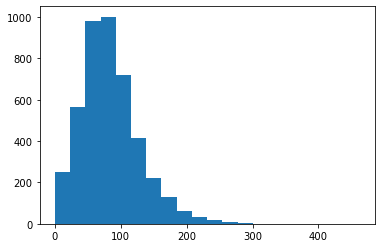

In [7]:
plt.hist(df['num_orders'], bins=20)
plt.show();

Наблюдается некоторая скошенность распределения вправо.

## 2. Обучение моделей

Создадим функция для разделения даты на элементы и введем лаг для расчета скользящней средней:

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df_1 = df.copy()
    df_1['year'] = df_1.index.year
    df_1['month'] = df_1.index.month
    df_1['day'] = df_1.index.day
    df_1['dayofweek'] = df_1.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_1['lag_{}'.format(lag)] = df_1['num_orders'].shift(lag)

    df_1['rolling_mean'] = df_1['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_1
    

Выберем значение для лага и скользящей средней:

In [23]:
df_1 = make_features(df,20,13)

Разделим данные на обучающую и тестовую выборки:

In [25]:
train, test = train_test_split(df_1, shuffle=False, test_size=0.1)
train = train.dropna()
target_train = train['num_orders']
features_train = train.drop("num_orders", axis=1)
target_test = test['num_orders']
features_test = test.drop("num_orders", axis=1)

Обучим следующие модели: линейную регрессию, случайный лес, CatBoost и LightGBM:

In [26]:
lr = LinearRegression()
lr.fit(features_train,target_train)

In [27]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 8)]
max_depth = [int(x) for x in np.linspace(10, 60, num = 8)]
max_depth.append(None)

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
print(random_grid)

In [29]:
rf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=3)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = tscv, verbose=2, random_state=12345, n_jobs = -1)
rf_random.fit(features_train, target_train)

In [30]:
rf_random.best_params_

In [31]:
best_rf = RandomForestRegressor(**rf_random.best_params_)
best_rf.fit(features_train, target_train)


In [32]:
cb_model = CatBoostRegressor()
tscv = TimeSeriesSplit(n_splits=5)
grid = {'max_depth': [3,6,10],'learning_rate':[0.01, 0.03, 0.05], 'iterations':[100, 500, 1000]}
gscv = GridSearchCV (estimator = cb_model, param_grid = grid, cv = tscv)
gscv.fit(features_train, target_train)

print(gscv.best_estimator_)

print(gscv.best_score_)

print(gscv.best_params_)

In [33]:
param_grid = {
    'num_leaves': [10, 50],
    'max_depth': [3,6,10],
    'learning_rate':[0.01, 0.03, 0.05],
    }

gbm = lgb.LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=5)
gbm_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=tscv)
gbm_search.fit(features_train, target_train)

## 3. Предсказания моделей

Рассчитаем RMSE для каждой модели:    

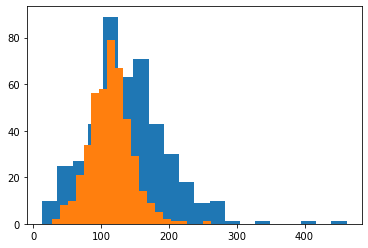

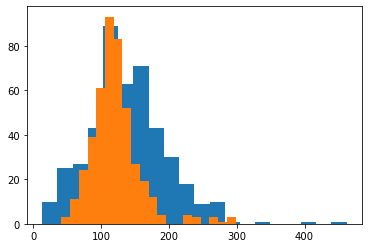

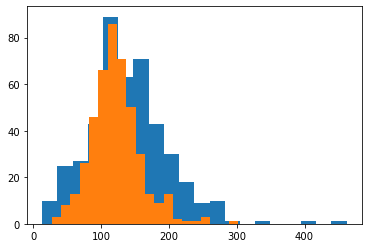

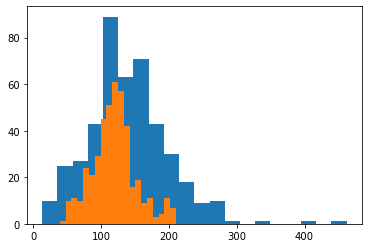

In [35]:
models = [lr, best_rf, gscv,gbm_search]
for model in models:
    y_pred = model.predict(features_test)
    print("Модель", model)
    print("Метрика RMSE на тестовой выборке равна:", mean_squared_error(target_test, y_pred) ** 0.5)
    plt.hist(target_test, bins=20)
    plt.hist(y_pred, bins=20)
    plt.show();

# Вывод

После многократной подстановки различных гиперпараметров все модели получили примерно одинаковые результаты. При этом, требуемый показатель метрики RMSE был достигнут только алгоритмом CatBoost.